In [1]:
import os
import json

In [2]:
folder_path = "/Users/surajk/Work/JIT-performance-logs/data/gpt"

In [3]:
def load_json(file_path):
    with open(file_path, 'r') as f:
        try:
            d = json.load(f)    
        except ValueError as e:
            print(e)
    return d

In [4]:
traces = {'_'.join(file.split('_')[0:6]): load_json(os.path.join(folder_path,file)) for file in os.listdir(folder_path)}
print(traces.keys())

dict_keys(['gm__jit_gpt2_lm_inference', 'gm__jit_logreg_multi_epoch', 'gm__jit_bert_bert_base'])


In [14]:
def get_rt_agg_report(d):
    events = d["data"]["traceEvents"]

    overall_rt = {}
    rt_idx = 0
    for e in events:
        if e['name'] == "runtime":
            if 'traceEvents' in e['args'] :
                print(f"Runtime context {rt_idx} has {len(e['args']['traceEvents'])} events")
                print(f"Time spent: { e['ts'] - start_ts } ns")
                rt_events = e['args']['traceEvents']

                # Hack we are ignoring the last event because its a metadata event.
                for idx in range(0, len(rt_events) - 1, 2):
                    assert (rt_events[idx]['name'] == rt_events[idx + 1]['name']) # Hack... but check
                    if (rt_events[idx]['name'] not in overall_rt):
                        overall_rt[rt_events[idx]['name']] = 0

                    overall_rt[rt_events[idx]['name']] += rt_events[idx + 1]['ts'] - rt_events[idx]['ts']  

                rt_idx += 1
                print("===============================================")
            else:
                print("===============================================")
                print(f"Args: {e['args']}")
                start_ts = e["ts"]
        else:
            pass
        
    return overall_rt

In [26]:
import matplotlib.pyplot as plt
def _bar_chart(data, title=""):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    langs = data.keys()
    students = data.values()
    ax.set(title="Runtime events performance (ns) - " + title)
    ax.bar(langs,students)
    plt.xticks(rotation=90)
    plt.show()

GPT2

In [24]:
gpt = get_rt_agg_report(traces['gm__jit_gpt2_lm_inference'])

Args: {'tensor names': '[None, None, None, None, None]', 'tensor size': '{1, 1, 20, 12, 64}'}
Runtime context 0 has 51 events
Time spent: 559599 ns
Args: {'tensor names': '[None, None, None, None]', 'tensor size': '{1, 20, 12, 12}'}
Runtime context 1 has 37 events
Time spent: 580711 ns
Args: {'tensor names': '[None, None, None]', 'tensor size': '{1, 12, 5120}'}
Runtime context 2 has 73 events
Time spent: 459889 ns
Args: {'tensor names': '[None, None, None, None, None]', 'tensor size': '{1, 1, 20, 12, 64}'}
Runtime context 3 has 69 events
Time spent: 451416 ns
Args: {'tensor names': '[None, None, None, None]', 'tensor size': '{1, 20, 12, 12}'}
Runtime context 4 has 37 events
Time spent: 448996 ns
Args: {'tensor names': '[None, None, None]', 'tensor size': '{1, 12, 5120}'}
Runtime context 5 has 73 events
Time spent: 456561 ns
Args: {'tensor names': '[None, None, None, None, None]', 'tensor size': '{1, 1, 20, 12, 64}'}
Runtime context 6 has 69 events
Time spent: 447938 ns
Args: {'tensor n

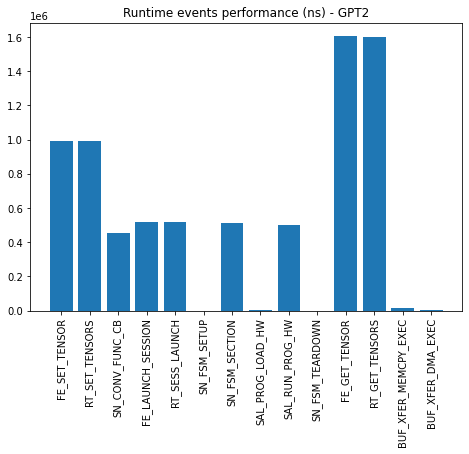

In [27]:
_bar_chart(gpt, "GPT2")

Logreg - 100 epochs

In [18]:
logreg = get_rt_agg_report(traces['gm__jit_logreg_multi_epoch'])

Args: {'tensor names': '[None, None]', 'tensor size': '{1, 2}'}
Runtime context 0 has 31 events
Time spent: 420468 ns
Args: {'tensor names': '[None, None]', 'tensor size': '{2, 16}'}
Runtime context 1 has 35 events
Time spent: 420620 ns
Args: {'tensor names': '[None, None]', 'tensor size': '{1, 2}'}
Runtime context 2 has 31 events
Time spent: 418795 ns
Args: {'tensor names': '[None, None]', 'tensor size': '{2, 16}'}
Runtime context 3 has 37 events
Time spent: 421080 ns
Args: {'tensor names': '[None, None]', 'tensor size': '{1, 2}'}
Runtime context 4 has 31 events
Time spent: 426260 ns
Args: {'tensor names': '[None, None]', 'tensor size': '{2, 16}'}
Runtime context 5 has 37 events
Time spent: 425564 ns
Args: {'tensor names': '[None, None]', 'tensor size': '{1, 2}'}
Runtime context 6 has 31 events
Time spent: 427054 ns
Args: {'tensor names': '[None, None]', 'tensor size': '{2, 16}'}
Runtime context 7 has 37 events
Time spent: 427998 ns
Args: {'tensor names': '[None, None]', 'tensor size'

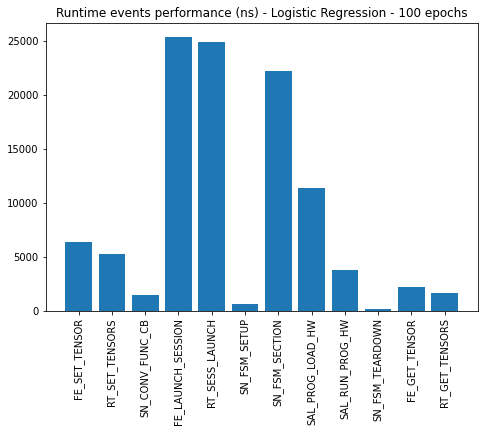

In [28]:
_bar_chart(logreg, 'Logistic Regression - 100 epochs')

In [20]:
bert = get_rt_agg_report(traces['gm__jit_bert_bert_base'])

Args: {'tensor names': '[None, None, None]', 'tensor size': '{1, 16, 30522}'}
Runtime context 0 has 1017 events
Time spent: 664371 ns


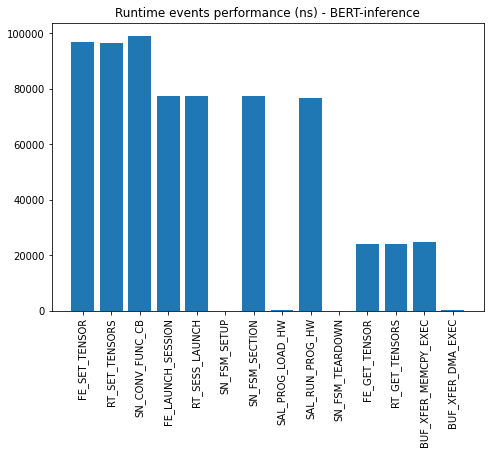

In [29]:
_bar_chart(bert, 'BERT-inference')